In [1]:
cd ..

/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project


In [2]:
import os
import json
import shutil
import tempfile
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss, DiceCELoss, FocalLoss, GeneralizedDiceFocalLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
    Compose,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR, UNet, SegResNet, UNETR
from monai import data
from monai.metrics import DiceMetric
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from functools import partial
from src.data.augmentations import *

import torch
import SimpleITK as sitk
from src.models.components.metrics import dice
from src.models.components.unetr.unetr import CustomUNETR

from einops import rearrange


/home/ikboljonsobirov/.conda/envs/qkv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [4]:
roi = (96,96,96)

In [5]:
class LoadImageTorch:
    def __init__(self):
        pass
    
    def __call__(self, path_to_data_dir):
        if path_to_data_dir is None:
            print('Please provide directory to the data path')
        else:
            img_data = self.read_torch_file(path_to_data_dir['path'])

            return img_data

            
    @staticmethod
    def read_torch_file(path):
        img = torch.load(path)
        return img


In [102]:
def get_loader(batch_size, sw_batch_size, data_dir, json_list, fold):
    data_dir = data_dir
    datalist_json = json_list

    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            LoadImageTorch(),
            # LoadImagedMonai(keys=["image","image2", "label"], ensure_channel_first = True),
            # transforms.SpatialPadd(keys=["image", "label"], spatial_size=(roi[0], roi[1], roi[2]), method='end'),
            transforms.RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=roi,
                pos=1,
                neg=1,
                num_samples=1,
                image_key="image",
                image_threshold=0,
            ),
            # transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            # # transforms.ScaleIntensityRanged(keys=["image"], a_min=-1024, a_max=1024, b_min=0.0, b_max=1.0, clip=True),
            # # ClipCT(keys=["image"]),

            # transforms.RandFlipd(
            #     keys=["image", "label"],
            #     spatial_axis=[0],
            #     prob=0.20,
            # ),
            # transforms.RandFlipd(
            #     keys=["image", "label"],
            #     spatial_axis=[1],
            #     prob=0.20,
            # ),
            # transforms.RandFlipd(
            #     keys=["image", "label"],
            #     spatial_axis=[2],
            #     prob=0.20,
            # ),
            # transforms.RandRotate90d(
            #     keys=["image", "label"],
            #     prob=0.20,
            #     max_k=3,
            # ),
            # transforms.RandShiftIntensityd(
            #     keys=["image"],
            #     offsets=0.10,
            #     prob=0.50,
            # ),
            # transforms.RandZoomd(   #added new
            #     keys=["image", "label"],
            #     prob = 0.5,
            #     min_zoom = 0.85,
            #     max_zoom = 1.15,
            #     mode = ['area', 'nearest'],
            # ),
            
    
            # transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
            # transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ]
    )

    val_transform = transforms.Compose(
        [
            LoadImageTorch(),
            # LoadImagedMonai(keys=["image", "image2", "label"], ensure_channel_first = True),
            # transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
            # # transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
            # # transforms.ScaleIntensityRanged(keys=["image"], a_min=-1024, a_max=1024, b_min=0.0, b_max=1.0, clip=True),
            # transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )
    train_ds = data.Dataset(data=train_files, transform=train_transform)


    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)

    val_loader = data.DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    return train_loader, val_loader, train_ds, val_ds

In [103]:
root_dir = ""


data_dir = '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/'
# data_dir_orig = '/Users/ikboljon.sobirov/Documents/sega23/SegAorta/'
datalist_json = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/files/train_json_torch.json'
batch_size = 2
sw_batch_size = 8
fold = 0 # 0,1,2,3,4
# roi = (64,64,64)
infer_overlap = 0.5

chkpt_path = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/logs/train/runs/2023-10-27_12-13-58/checkpoints/epoch_076.ckpt'
# chkpt_path = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/logs/train/runs/segresnet_fold0/checkpoints/epoch_088.ckpt'

In [104]:
train_loader, val_loader, train_ds, val_ds = get_loader(batch_size, sw_batch_size, data_dir, datalist_json, fold)

In [105]:
a = next(iter(val_loader))

In [106]:
torch.unique(a['seg']), a['ctpt'].shape, a['id']

(metatensor([0., 1., 2.]),
 torch.Size([2, 2, 200, 200, 310]),
 ['CHUV-008', 'MDA-024'])

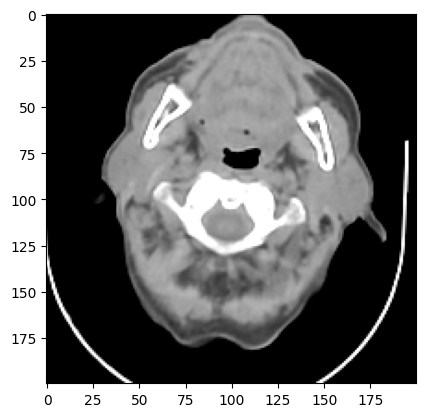

In [107]:
plt.imshow(a['ctpt'][0,1,:,:, 150], cmap='gray')

In [108]:
def load_model_weights(model, path_to_model_weights):
    model_state_dict = torch.load(path_to_model_weights, map_location=lambda storage, loc: storage)
    state_dict = model_state_dict['state_dict']
    del state_dict['dice_loss.dice.class_weight']
    
    for key in list(state_dict):
        # if dice_loss exists in then state_dict, remove it
        # if key != 'dice_loss.dice.class_weight':
        

        if 'model.' in key:
            state_dict[key.replace("model.", "")] = state_dict.pop(key)

    model.load_state_dict(state_dict)
    return model

In [109]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# model = CustomUNETR(in_channels=2, 
#                                out_channels=3, 
#                             #    feature_size=24,
#                                img_size=roi,
#                                )
# model = UNETR(in_channels=2, 
#                                out_channels=3, 
#                                img_size=roi)

# model = SegResNet(
#                             in_channels=2, out_channels=3, init_filters=16)

model = SegResNet(
                            in_channels=2, 
                            out_channels=3, 
                            init_filters=32,
                            norm='BATCH', 
                            blocks_down=(1,2,2,4,4,4), 
                            blocks_up=(1,1,1,1,1), 
                            upsample_mode='deconv',)

# model = CustomUNETR(in_channels=2, 
#                                out_channels=1, 
#                                img_size=roi)

model = load_model_weights(model, chkpt_path)

model = model.to(device)


In [110]:
# post_sigmoid = Activations(softmax=True)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
post_label = AsDiscrete(to_onehot=3)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")
# dice_acc = DiceMetric(include_background=False, reduction="mean",get_not_nans=True)
# model_inferer = partial(
#     sliding_window_inference,
#     roi_size=[roi[0], roi[1], roi[2]],
#     sw_batch_size=sw_batch_size,
#     predictor=model,
#     overlap=infer_overlap,
# )



In [111]:
# dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)

In [112]:
metric_dictionary = {}
metric_dictionary['id'] = []
metric_dictionary['dice'] = []
metric_dictionary['dice_t'] = []
metric_dictionary['dice_n'] = []

In [113]:
pred_list = []
label_list = []

In [114]:
model.eval()
# run_acc = AverageMeter()
# start_time = time.time()
# inference_times = []
# orig_path = "segaorta"
counter = 0

inference_path = "/share/nvmedata/ikboljonsobirov/fusion_vit/inference/"
os.makedirs(inference_path, exist_ok=True)

run_acc_val = AverageMeter()

with torch.no_grad():
    for idx, sample in enumerate(val_loader):
        counter += 1

        pat_id = sample['id'][0].split('/')[-1]
        
        val_inputs, val_labels = sample["ctpt"].to(device), sample["seg"].to(device)

        print(torch.unique(val_labels), val_labels.shape, pat_id)
        # break

        logits = sliding_window_inference(val_inputs, roi, 4, model, infer_overlap)
        
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        
        val_outputs_list = decollate_batch(logits)

        val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

        # print("logits: ", logits.shape)
        # print("val_labels: ", val_labels.shape)
        # print("after")
        # print("after oist processing pred: ", val_output_convert[0].shape)
        # print("after oist processing label: ", val_labels_convert[0].shape)
        # break
        

        dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        dice_metric_batch(y_pred=val_output_convert, y=val_labels_convert)

        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()

        # break

        
        
        pat_id = sample['id'][0].split('/')[-1]
        print("Processing: ", pat_id, " Dice: ", mean_dice_val)

        metric_dictionary['id'].append(pat_id)
        metric_dictionary['dice'].append(mean_dice_val)
        metric_dictionary['dice_t'].append(metric_tumor)
        metric_dictionary['dice_n'].append(metric_lymph)

        # break
        
        # # break
        # val_outputs = sliding_window_inference(val_inputs, roi, sw_batch_size, model)
        # y_pred = post_sigmoid(val_outputs)
        # # val_labels = post_label(val_labels)

        # # y_pred = torch.where(val_outputs>0.5, 1, 0).float()
        # # y_pred = y_pred.squeeze(0)
        # dsc = dice_metric(y_pred.detach(), val_labels.detach())
        # print(dsc)
        # break
        merged_channels_pred = torch.argmax(val_output_convert[0], dim=0)
        sitk_pred = merged_channels_pred.cpu().numpy()
        merged_channels_label = torch.argmax(val_labels_convert[0], dim=0)
        sitk_label = merged_channels_label.cpu().numpy()

        pred_list.append(sitk_pred)
        label_list.append(sitk_label)
        sitk_pred = rearrange(sitk_pred, 'h w d -> d h w')
        
        sitk_pred = sitk.GetImageFromArray(sitk_pred)
        
        if not os.path.exists(os.path.join(inference_path, pat_id)):
                    os.makedirs(os.path.join(inference_path, pat_id), exist_ok=True)

        # sitk.WriteImage(sitk_pred,  os.path.join(inference_path, pat_id, (pat_id +'_pred.seg.nrrd')), useCompression=True)
        # if counter == 3:
        # break
        

metatensor([0., 1., 2.], device='cuda:3') torch.Size([2, 1, 200, 200, 310]) CHUV-008
Processing:  CHUV-008  Dice:  0.7702665328979492
metatensor([0., 1., 2.], device='cuda:3') torch.Size([2, 1, 200, 200, 310]) CHUS-052
Processing:  CHUS-052  Dice:  0.7330507040023804
metatensor([0., 1., 2.], device='cuda:3') torch.Size([2, 1, 200, 200, 310]) CHUS-049
Processing:  CHUS-049  Dice:  0.6427240371704102
metatensor([0., 1., 2.], device='cuda:3') torch.Size([2, 1, 200, 200, 310]) MDA-028
Processing:  MDA-028  Dice:  0.6795116662979126
metatensor([0., 1., 2.], device='cuda:3') torch.Size([2, 1, 200, 200, 310]) MDA-023
Processing:  MDA-023  Dice:  0.5785760879516602
metatensor([0., 1.], device='cuda:3') torch.Size([2, 1, 200, 200, 310]) CHUP-068
Processing:  CHUP-068  Dice:  0.7767137885093689
metatensor([0., 1., 2.], device='cuda:3') torch.Size([2, 1, 200, 200, 310]) CHUS-078
Processing:  CHUS-078  Dice:  0.4128858149051666
metatensor([0., 1., 2.], device='cuda:3') torch.Size([2, 1, 200, 200, 

In [115]:
# # plot the sitk_pred mask and ctpt side by side
# plt.figure(figsize=(20,10))
# plt.subplot(1,2,1)
# plt.imshow(sitk_pred[:,:,150], cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(a['ctpt'][0,1,:,:, 150], cmap='gray')
# plt.show()



In [116]:
# # plot sitk_pred prediction mask on top of the ct image slice
# plt.imshow(sitk_pred[:,:,150], cmap='gray')
# plt.imshow(a['ctpt'][0,1,:,:, 150], cmap='gray', alpha=0.4)


In [117]:
np.mean(metric_dictionary['dice']), np.mean(metric_dictionary['dice_t']), np.mean(metric_dictionary['dice_n'])

(0.6419021799316946, 0.671412597287376, 0.5868565635579936)

(0.59503865, 0.63700664, 0.55307066)


In [118]:
def dice_hecktor(pred_list, label_list):
    agg_dsc = []

    for i in range(1, 3):
        for pred, label in zip(pred_list, label_list):
            numerator, denominator = None, None

            organ_arr_result = np.where(pred == i, 1, 0)
            organ_arr_refer = np.where(label == i, 1, 0)

            curr_numerator = np.sum(np.multiply(organ_arr_result, organ_arr_refer))
            curr_denominator = np.sum(organ_arr_result + organ_arr_refer)

            if numerator is None:
                numerator = curr_numerator
                denominator = curr_denominator
            else:
                numerator += curr_numerator
                denominator += curr_denominator

        agg_dsc.append(2 * numerator / denominator)

    agg_dsc_GTVp = agg_dsc[0]
    agg_dsc_GTVn = agg_dsc[1]
    avg_dsc = (agg_dsc_GTVp + agg_dsc_GTVn) / 2

    return agg_dsc_GTVp, agg_dsc_GTVn, avg_dsc


In [119]:
a, b, c = dice_hecktor(pred_list, label_list)

In [120]:
print("GTVp: ", a, " GTVn: ", b, " Avg: ", c)

GTVp:  0.8514895650788593  GTVn:  0.7108230961765298  Avg:  0.7811563306276945


In [121]:
def compute_agg_dice(intermediate_results):
    """
    Compute the aggregate dice score from the intermediate results
    """
    aggregate_results = {}
    TP1s = [v["TP1"] for v in intermediate_results]
    TP2s = [v["TP2"] for v in intermediate_results]
    vol_sum1s = [v["vol_sum1"] for v in intermediate_results]
    vol_sum2s = [v["vol_sum2"] for v in intermediate_results]
    DSCagg1 = 2 * np.sum(TP1s) / np.sum(vol_sum1s)
    DSCagg2 = 2 * np.sum(TP2s) / np.sum(vol_sum2s)
    aggregate_results['AggregatedDsc'] = {
        'GTVp': DSCagg1,
        'GTVn': DSCagg2,
        'mean': np.mean((DSCagg1, DSCagg2)),
    }

    return aggregate_results

def compute_volumes(im):
    """
    Compute the volumes of the GTVp and the GTVn
    """
    spacing = im.GetSpacing()
    voxvol = spacing[0] * spacing[1] * spacing[2]
    stats = sitk.LabelStatisticsImageFilter()
    stats.Execute(im, im)
    nvoxels1 = stats.GetCount(1)
    nvoxels2 = stats.GetCount(2)
    return nvoxels1 * voxvol, nvoxels2 * voxvol


def get_intermediate_metrics(groundtruth, prediction):
    """
    Compute intermediate metrics for a given groundtruth and prediction.
    These metrics are used to compute the aggregate dice.
    """
    groundtruth = sitk.GetImageFromArray(groundtruth)
    prediction = sitk.GetImageFromArray(prediction)
    
    overlap_measures = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures.SetNumberOfThreads(1)
    overlap_measures.Execute(groundtruth, prediction)

    DSC1 = overlap_measures.GetDiceCoefficient(1)
    DSC2 = overlap_measures.GetDiceCoefficient(2)

    vol_gt1, vol_gt2 = compute_volumes(groundtruth)
    vol_pred1, vol_pred2 = compute_volumes(prediction)

    vol_sum1 = vol_gt1 + vol_pred1
    vol_sum2 = vol_gt2 + vol_pred2
    TP1 = DSC1 * (vol_sum1) / 2
    TP2 = DSC2 * (vol_sum2) / 2
    return {
        "TP1": TP1,
        "TP2": TP2,
        "vol_sum1": vol_sum1,
        "vol_sum2": vol_sum2,
    }


In [122]:
new_dices = []
for l, p in zip(label_list, pred_list):
    new_dices.append(get_intermediate_metrics(l, p))
    

LabelOverlapMeasuresImageFilter (0x7f6400026750): Label 2 not found.

LabelOverlapMeasuresImageFilter (0x7f6400026750): Label 2 not found.

LabelOverlapMeasuresImageFilter (0x7f6400026750): Label 2 not found.

LabelOverlapMeasuresImageFilter (0x7f6400026750): Label 2 not found.



In [123]:
print(compute_agg_dice(new_dices))

{'AggregatedDsc': {'GTVp': 0.8069137628246603, 'GTVn': 0.7372585466328402, 'mean': 0.7720861547287503}}


In [55]:
dicess = compute_agg_dice(new_dices)

In [56]:
dicess['AggregatedDsc']['mean']

0.7407033200595364